# Wald-RL Model Fitting

## Section 1: Motivating the model
### Reaction time effects

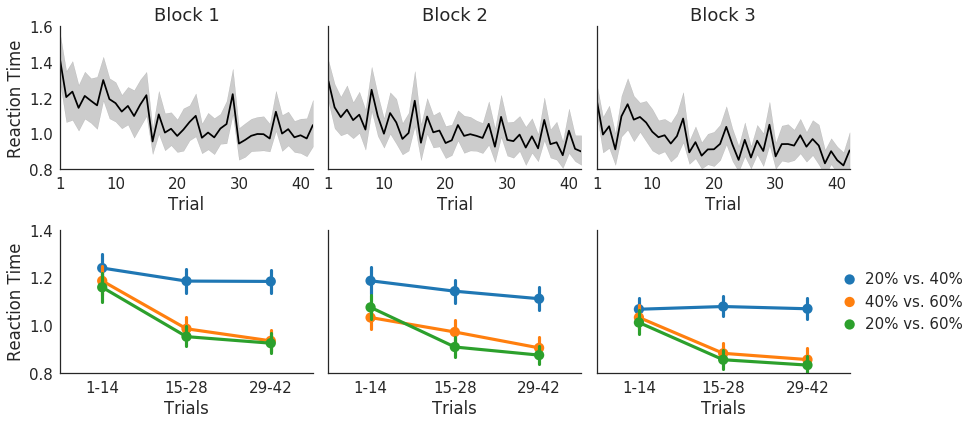

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Categorical, DataFrame, read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]

## Define trial types (e.g. 20% vs. 40%).
cond = np.where(data[['M1','M2']] % 3, data[['M1','M2']] % 3, 3).sum(axis=1)
cond = Categorical(cond, categories=[3,5,4], ordered=True).rename_categories(['20% vs. 40%', 
                                                                              '40% vs. 60%', 
                                                                              '20% vs. 60%'])
data['Cond'] = cond

## Bin trials into thirds.
data['Bins'] = (data.Trial - 1) // 14

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, 3, figsize=(12,6))

## Plot.
for i in np.arange(3):
    
    ## Plot RT timeseries.
    sns.lineplot('Trial', 'RT', data=data[data.Block==i+1], color='k', zorder=0, ax=axes[0,i])
    ax=axes[0,i].set(xlim=(1,42), xticks=[1,10,20,30,40], ylim=(0.8,1.6), 
                     yticks=[], ylabel='', title='Block %s' %(i+1))
    if not i: axes[0,i].set(yticks=np.arange(0.8,1.7,0.2), ylabel='Reaction Time')

    ## Plot RT bins.
    sns.pointplot('Bins', 'RT', 'Cond', data=data[data.Block==i+1], ax=axes[1,i])
    axes[1,i].set(xticklabels=['1-14','15-28','29-42'], xlabel='Trials', ylim=(0.8,1.4),
                  yticks=[], ylabel='')
    axes[1,i].legend_.set_visible(False)
    if not i: axes[1,i].set(yticks=np.arange(0.8,1.5,0.2), ylabel='Reaction Time')

axes[1,2].legend(loc=7,bbox_to_anchor=(1.5,0.5),handletextpad=0)
        
sns.despine()
plt.tight_layout()

### Sources of speed-up

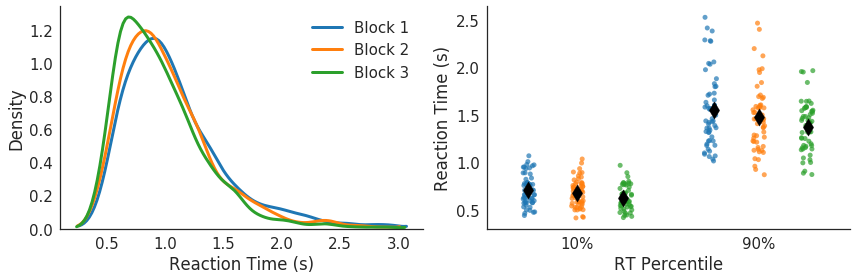

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Set True you want to include post-query trials.
## Does not make a major effect.
mask = False
query_trials = [8,15,22,29,36]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare percentile data (10%, 90%).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if mask: perc = data[[True if t not in query_trials else False for t in data.Trial]].copy()
else: perc = data.copy()
    
## Compute percentile data.
perc = perc.groupby(['Block','Datetime']).RT.apply(lambda arr: np.nanpercentile(arr, [10,90])).reset_index()
perc['10%'] = perc.RT.apply(lambda arr: arr[0])
perc['90%'] = perc.RT.apply(lambda arr: arr[1])

## Melt and reshape DataFrame for plotting.
perc = perc.drop('RT', 1).melt(id_vars=('Block','Datetime'), var_name='Percentile', value_name='RT')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot KDE.
for i in np.arange(3): sns.kdeplot(data.loc[data.Block==i+1,'RT'].dropna(), lw=3, cut=1,
                                   label='Block %s' %(i+1), ax=axes[0])
axes[0].set(xlabel='Reaction Time (s)', ylabel='Density')
    
## Plot stripplot.
sns.stripplot('Percentile', 'RT', 'Block', data=perc, dodge=True, jitter=True, alpha=0.7, ax=axes[1])
axes[1].scatter([-0.27,0,0.25,0.75,1,1.27], perc.groupby(['Percentile','Block']).RT.mean().values,
                s=150, marker='d', color='k', zorder=100)
axes[1].set(xlabel='RT Percentile', ylabel='Reaction Time (s)')
axes[1].legend_.set_visible(False)

sns.despine()
plt.tight_layout()

In [3]:
from spm1d.stats import anova1rm

for p in perc.Percentile.unique():

    ## Prepare data.
    ix, = np.where(perc.Percentile==p)
    Y = perc.loc[ix, 'RT'].values
    _, A = np.unique(perc.loc[ix, 'Block'], return_inverse=True)
    _, SUBJ = np.unique(perc.loc[ix, 'Datetime'], return_inverse=True)
    
    ## Fit 1-way repeated measures ANOVA.
    fit = anova1rm(Y, A, SUBJ).inference(alpha=0.05)
    print('%s RT: F = %0.3f, p = %0.3f' %(p, fit.z, fit.p))

10% RT: F = 19.985, p = 0.000
90% RT: F = 9.962, p = 0.000


### Task-switching

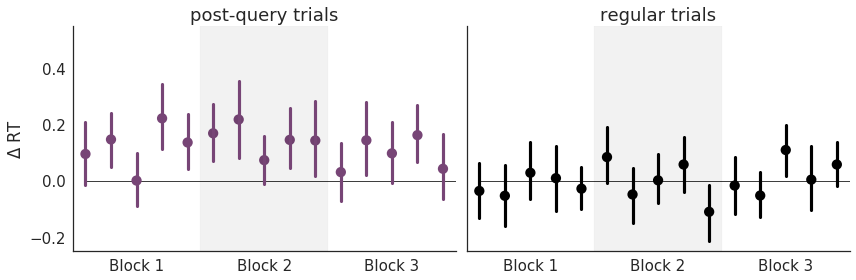

In [4]:
query_trials = np.array([8,15,22,29,36])

## Reshape RT data.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
RT = data.RT.values.reshape(N,B,T)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)

for i, ax, color, title in zip(range(2), axes, ['#774576','k'], ['post-query trials', 'regular trials']):

    query_trials += i * 3
    
    ## Preallocate space.
    penalty = np.zeros((N,B,len(query_trials)))

    ## Iteratively compute RT penalty.
    for j, qt in enumerate(query_trials):
        penalty[...,j] = RT[...,qt-1] - RT[...,[qt-2,qt]].mean(axis=-1)

    ## Convert to DataFrame.
    penalty = DataFrame(penalty.reshape(N,B*len(query_trials)))
    penalty = penalty.melt(var_name='Query', value_name='RT')
    
    ## Plot.
    sns.pointplot('Query', 'RT', data=penalty, join=False, color=color, ax=ax)
    ax.hlines(0,0,15,zorder=0,lw=0.75)
    ax.fill_between([4.5,9.5],-0.25,0.55,color='k',alpha=0.05)
    ax.set(xticks=np.arange(2,15,5), xticklabels=['Block 1', 'Block 2', 'Block 3'],
           xlabel='', ylim=(-0.25,0.55), ylabel='', title=title)
    if not i: ax.set_ylabel(r'$\Delta$ RT')
        
sns.despine()
plt.tight_layout()

### Likelihood of drift rates

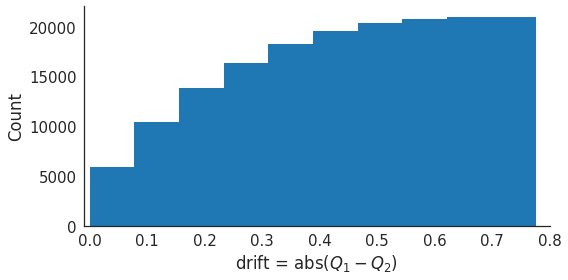

In [5]:
from scripts.simulations import slot_machine_game, softmax

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define simulation parameters.
n_sim = 500
n_trials = 42

## Define agent parameters.
beta = 9
eta_v = 0.09

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
drift = np.zeros((n_sim, n_trials))

test = np.zeros(3)
for i in np.arange(n_sim):
    
    ## Simulate block.
    x, r = slot_machine_game(n_trials=n_trials, reward=1)

    ## Initialize Q-values.
    Q = np.zeros(3)
    
    ## Simulate behavior.
    for j in np.arange(n_trials):
        
        ## Store drift.
        drift[i,j] = np.abs(np.diff(Q[x[j]]))
        
        ## Simulate choice.
        p = softmax(beta * Q[x[j]])
        y = np.argmax(np.random.multinomial(1, p))
                                
        ## Compute reward prediction error.
        delta = r[j,y] - Q[x[j,y]]

        ## Update expectations.
        Q[x[j,y]] += eta_v * delta

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
# sns.distplot(drift.flatten(), kde=False, cumu hist_kws=dict(alpha=1, edgecolor='w'), ax=ax)
ax.hist(drift.flatten(), cumulative=True)
ax.set(xlim=(-0.01,0.8), xlabel='drift = abs($Q_1 - Q_2$)', ylabel='Count')

sns.despine()
plt.tight_layout()

### Priors on shifted Wald distribution

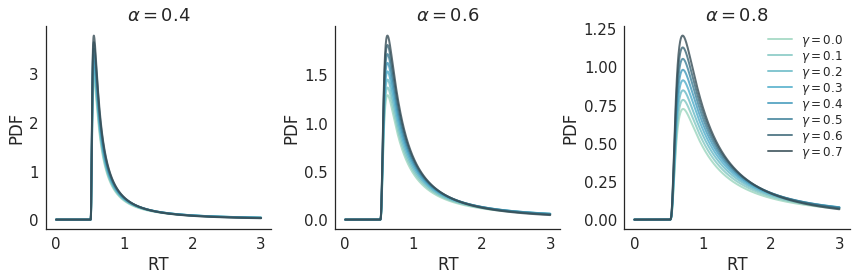

In [6]:
from scripts.wald import shifted_wald_pdf

## Define parameters.
gamma = np.arange(0,0.8,0.1)
alpha = [0.4, 0.6, 0.8]
theta = 0.5

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))
palette = sns.color_palette('GnBu_d', n_colors=gamma.size)

x = np.linspace(0,3,1000)
for ax, a in zip(axes, alpha):
    
    for g, color in zip(gamma, palette[::-1]):
        
        ## Plot PDF.
        ax.plot(x, shifted_wald_pdf(x, g, a, theta), label=r'$\gamma = %0.1f$' %g,
                lw=2, color=color, alpha=0.8)

    ## Add info.
    ax.set(xlabel='RT', ylabel='PDF', title=r'$\alpha = %s$' %a)
        
## Add legend.
ax.legend(loc=1, borderpad=0, labelspacing=0, fontsize=12)
        
sns.despine()
plt.tight_layout()

## Section 2: RT-only Models

In [7]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import *
from scripts.utilities import zscore
from scripts.wald import init_wald_mixed
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 3]
data = data.dropna()

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = metadata.Subject.max()
T = data.shape[0]
B = data.Block.max()
C = 5

## Extract and prepare RT data.
Z = data.RT.values

## Extract and prepare design matrix.
X = np.zeros((N,B,C))
X[...,0] = np.ones_like(X[...,0])                  # Intercept
X[:,1,1] = np.ones_like(X[:,1,1])                  # Block index

for i in np.arange(B):
    X[:,i,2] = np.where(metadata.WoF > 0, 1, 0)    # Wheel of Fortune 
    X[:,i,3] = zscore(metadata.IPIP_hps)           # HPS measure
    X[:,i,4] = X[:,i,2] * X[:,i,3]                 # WoF * HPS interaction

## Define indices.
subj_ix = data.Subject.values
block_ix = data.Block.values

## Organize data dictionary.
dd = dict(N=N, T=T, B=B, C=C, subj_ix=subj_ix, block_ix=block_ix, Z=Z, X=X)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Initialize parameters.
    init = init_wald_mixed(N, B, C, chains)
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      init=init, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit); check_n_eff(fit), check_rhat(fit)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    print('Done.')

<IPython.core.display.Javascript object>

### Visualize group-level effects

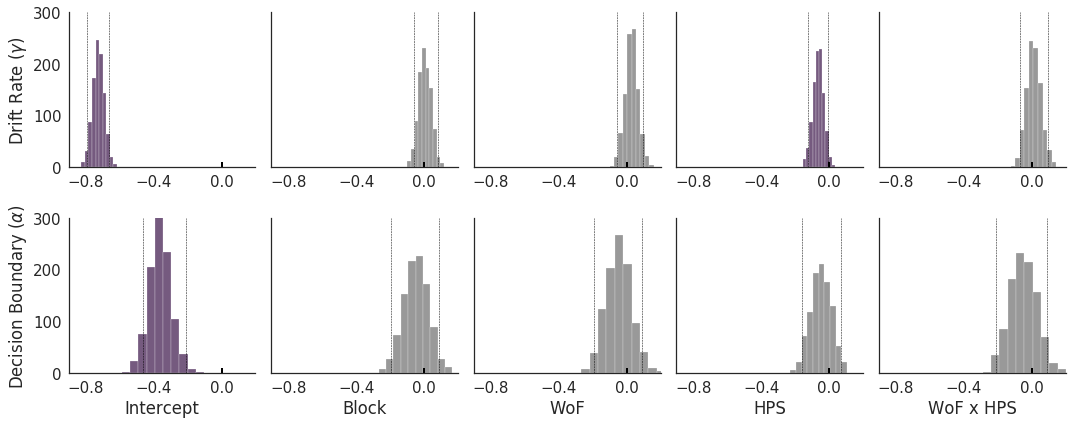

In [8]:
from scripts.utilities import load_fit, HDIofMCMC

## Load and prepare data.
fit = load_fit('moodRL_wald_mixed')
mu = fit['mu_pr']

## Initialize canvas.
fig, axes = plt.subplots(2, 5, figsize=(15,6), sharey=True)

## Iteratively plot.
for i in np.arange(2):
    
    for j in np.arange(5):
        
        ## Select color.
        lb, ub = HDIofMCMC(mu[:,i,j], 0.95)
        if np.logical_xor(lb > 0, ub > 0): color='grey'
        else: color = '#52315f'
        
        ## Plot histogram.
        sns.distplot(mu[:,i,j], bins=10, kde=False, color=color,
                     hist_kws=dict(edgecolor='w',alpha=0.8), ax=axes[i,j])
        
         ## Plot HDI.
        axes[i,j].vlines([lb,ub],0,300,lw=0.5,linestyle='--')
        axes[i,j].vlines(0,0,10,lw=2,color='k')
        axes[i,j].set(xlim=(-0.9,0.2), xticks=np.arange(-0.8,0.2,0.4), ylim=(0,300))
        
## Add info.
axes[0,0].set_ylabel(r'Drift Rate ($\gamma$)')
axes[1,0].set_ylabel(r'Decision Boundary ($\alpha$)')
for ax, xlabel in zip(axes[1,:],['Intercept','Block','WoF','HPS','WoF x HPS']): ax.set_xlabel(xlabel)
    
sns.despine()
plt.tight_layout()

## Section 3: Model Fitting

In [9]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import *
from scripts.utilities import normalize
from scripts.plotting import plot_subject , plot_subject_rt
from scripts.wald import init_shifted_wald, wald_generate_quantities
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Extract and prepare stimulus presentation data.
## Stimulus presentation is sorted such that the
## more valuable machine occupies the right column.
X = data[['M1','M2']].values
X = np.sort(X, axis=-1) 

## Extract and prepare choice data. Choice data 
## recoded to range [1, 2], where 1 = less valuable, 
# 2 = more valuable. 
Y = data.Choice.values
Y = np.equal(X[:,-1], Y).astype(int)

## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values
R = np.where(R > 0, 1, 0)

## Extract and prepare RT data.
Z = data.RT.values

## Extract and prepare mood data. All data
## scaled between [1,9].
M = ratings.loc[ratings.Trial>0, 'Rating'].values / 4

m2 = ratings.loc[np.logical_and(ratings.Block==2, ratings.Trial==0),'Rating'].values / 4
m2 = np.where(m2==-1, -0.99, np.where(m2==1, 0.99, m2))

## Define subject index.
_, subj_ix = np.unique(data.Subject, return_inverse=True)
subj_ix += 1

## Define mood index.
mood_ix = np.in1d(data.Trial, [7,21,35]).astype(int)
shift, = np.where(np.logical_and(mood_ix, data.RT < 0))
mood_ix[shift] = 0
mood_ix[shift-1] = 1
mood_ix[np.where(mood_ix)] = np.arange(mood_ix.sum()) + 1

## Define block index.
block_ix = np.zeros_like(mood_ix)
block_ix[np.logical_and(data.Block==1, data.Trial==1)] = 1
block_ix[np.logical_and(data.Block==2, data.Trial==1)] = 2

## Remove trials with missing data.
X = X[data.RT > 0]
Y = Y[data.RT > 0]
R = R[data.RT > 0]
Z = Z[data.RT > 0]
subj_ix = subj_ix[data.RT > 0]
mood_ix = mood_ix[data.RT > 0]
block_ix = block_ix[data.RT > 0]

## Define metadata.
N = data.Subject.max()
T = Y.size

## Organize data dictionary.
dd = dict(N=N, T=T, subj_ix=subj_ix, mood_ix=mood_ix, block_ix=block_ix,
          X=X, Y=Y, R=R, Z=Z, M=M, m2=m2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Definite initial parameters.
    if model_name == 'moodRL_wald_no_mood.stan':
        init = init_shifted_wald(N, 4, chains)
    elif model_name == 'moodRL_wald_no_mood_bias.stan':
        init = init_shifted_wald(N, 5, chains)
    elif 'full_mood' in model_name:
        init = init_shifted_wald(N, 6, chains)
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      init=init, control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit); check_n_eff(fit), check_rhat(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Generated quantities.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Extract parameters.
    extract = fit.extract()

    ## Store metadata.
    extract['N'] = data.Datetime.unique().size
    extract['B'] = data.Block.max()
    extract['T'] = data.Trial.max()

    ## Store trial information.
    extract['X'] = np.sort(data[['M1','M2']].values.reshape(extract['N'],extract['B'],extract['T'],2),axis=-1)
    extract['Y'] = data.Choice.values.reshape(extract['N'],extract['B'],extract['T'],1)
    extract['Y'] = np.where(np.any(np.equal(extract['X'], extract['Y']), axis=-1), 
                            np.argmax(np.equal(extract['X'], extract['Y']), axis=-1) + 1, -1 )
    extract['R'] = np.where(data.Outcome.values.reshape(extract['N'],extract['B'],extract['T']) > 0, 1, 0)
    extract['Z'] = data.RT.values.reshape(extract['N'],extract['B'],extract['T'])
    extract['M'] = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(extract['N'],extract['B'],3) / 4
    extract['m2'] = ratings.loc[np.logical_and(ratings.Block==2, ratings.Trial==0),'Rating'].values / 4
    extract['m2'] = np.where(extract['m2']==-1, -0.99, np.where(extract['m2']==1, 0.99, extract['m2']))

    ## Compute generated quantities.
    if 'rel' in stan_model: rel=True
    else: rel=False
    extract = wald_generate_quantities(extract, rel=rel)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot subjects.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Make plots dir.
    plots_dir = os.path.join(out_dir, 'plots')
    if not os.path.isdir(plots_dir): os.makedirs(plots_dir)

    ## Iteratively plot.
    for i in np.arange(extract['N']):

        ## Plot behavior and save.
        fig, axes = plot_subject(extract, i)
        fig.savefig(os.path.join(plots_dir, 'subj_%s.png' %(i+1)), dpi=180)
        plt.close('all')
        
        ## Plot RTs and save.
        fig, axes = plot_subject_rt(extract, i, ds=2)
        fig.savefig(os.path.join(plots_dir, 'subj_%s_rt.png' %(i+1)), dpi=180)
        plt.close('all')
        
    print('Done.')

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


## Section 4: Model comparison
### Equivalence of *no mood* models

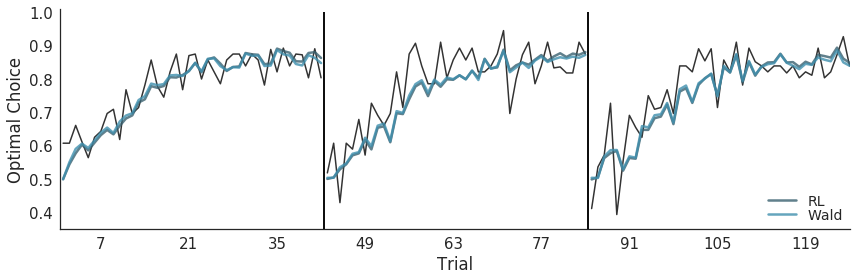

In [10]:
from scripts.plotting import plot_group_behavior

## Define parameters.
models = ['moodRL_centered_no_mood', 'moodRL_wald_no_mood']
labels = ['RL', 'Wald']
colors = sns.color_palette('GnBu_d', n_colors=4)

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [1,0,0,0], colors, labels):
    plot_group_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=14, labelspacing=0)

sns.despine()
plt.tight_layout()

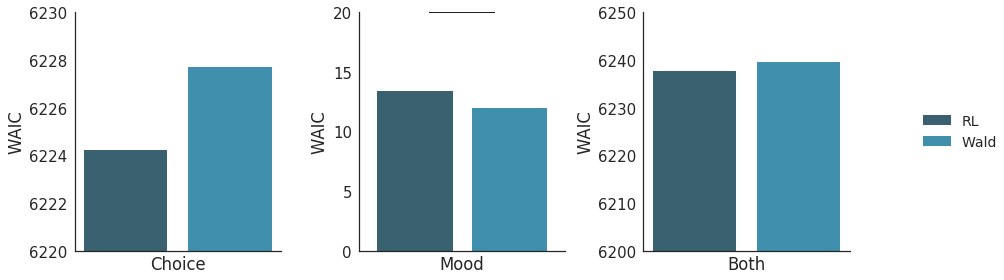

In [11]:
from scripts.utilities import model_comparison

fig, axes = plt.subplots(1,3,figsize=(12,4))
xlabels = ['Choice', 'Mood', 'Both']
ylimits = np.array([(6220,6230), (0,20), (6200,6250)])
comparisons = ['y', 'm', ('y','m')]

for ax, include, xlabel, ylim in zip(axes, comparisons, xlabels, ylimits):
    
    for i in np.arange(1,len(models)):
        
        ## Perform model comparison.
        w1, w2, se = model_comparison(models[i-1], models[i], include=include, verbose=False)
        
        ## Plot.
        ax.bar([i-1,i],[w1,w2],color=colors[i-1:i+1])
        
        ## Add difference.
        if np.abs(w1 - w2) > se: ax.hlines(ylim[1], i-0.85, i-0.15 )
        
    if np.logical_xor(*ylim>0): ax.hlines(0,*ax.get_xlim(),lw=0.5)
    ax.set(xticks=[], xlabel=xlabel, ylim=ylim, ylabel='WAIC')
    
## Add legend.
for color, label in zip(colors, labels): ax.bar(0,0,color=color,label=label)
ax.legend(loc=7, bbox_to_anchor=(1.75,0.5), fontsize=14, borderpad=0)
    
sns.despine()
plt.tight_layout()

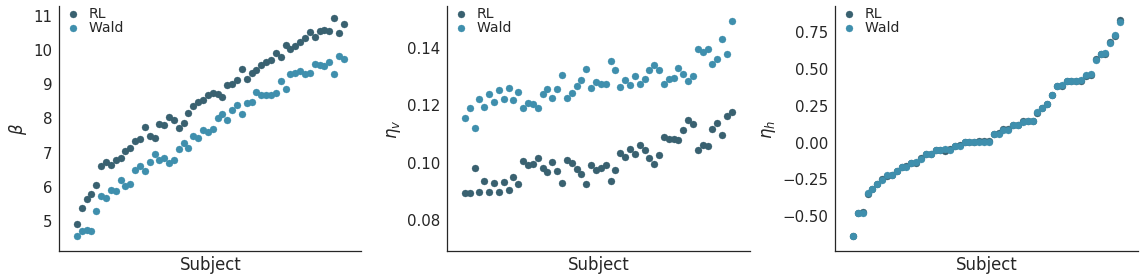

In [12]:
from scripts.utilities import load_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(16,4))

## Plot beta.
beta = [np.median(load_fit(model)['beta'], axis=0) for model in models]
sort_ix = np.argsort(np.mean(beta, axis=0))
for arr, color, label in zip(beta,colors, labels): 
    axes[0].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[0].set(xticks=[], xlabel='Subject', ylabel=r'$\beta$')
axes[0].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)
    
## Plot eta_v.
eta_v = [np.median(load_fit(model)['eta_v'], axis=0) for model in models]
sort_ix = np.argsort(np.mean(eta_v, axis=0))
for arr, color, label in zip(eta_v,colors,labels): 
    axes[1].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[1].set(xticks=[], xlabel='Subject', ylabel=r'$\eta_v$')
axes[1].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)
    
## Plot beta_h.
beta_h = [np.median(load_fit(model)['beta_h'], axis=0) for model in models]
sort_ix = np.argsort(np.mean(beta_h, axis=0))
for arr, color, label in zip(beta_h,colors,labels): 
    axes[2].scatter(np.arange(arr.size), arr[sort_ix], color=color, label=label)
axes[2].set(xticks=[], xlabel='Subject', ylabel=r'$\eta_h$')
axes[2].legend(loc=2, borderpad=-0.5, labelspacing=0, handletextpad=0.1, fontsize=14)

sns.despine()
plt.tight_layout()

### Wald Model Comparisons 

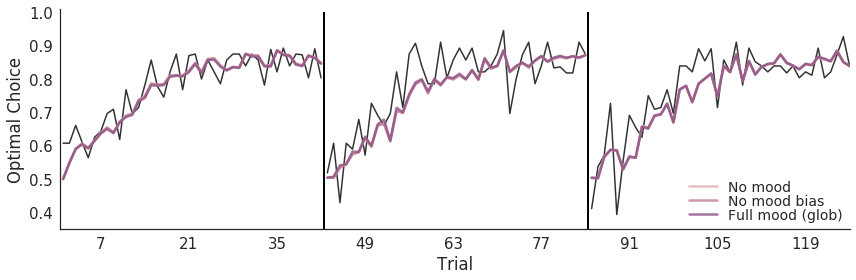

In [16]:
## Define parameters.
models = ['moodRL_wald_no_mood', 'moodRL_wald_no_mood_bias', 'moodRL_wald_full_mood_glob']
labels = ['No mood', 'No mood bias', 'Full mood (glob)']
colors = sns.cubehelix_palette(n_colors=4, light=0.75, dark=0.25)

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [1,0,0,0], colors, labels):
    plot_group_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=14, labelspacing=0)

sns.despine()
plt.tight_layout()

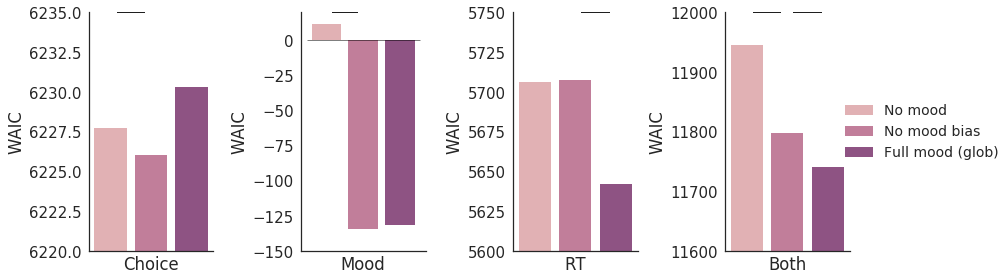

In [17]:
from scripts.utilities import model_comparison

fig, axes = plt.subplots(1,4,figsize=(12,4))
xlabels = ['Choice', 'Mood', 'RT', 'Both']
ylimits = np.array([(6220,6235), (-150,20), (5600,5750), (11.6e3,12e3)])
comparisons = ['y', 'm', 'z', ('y','m','z')]

for ax, include, xlabel, ylim in zip(axes, comparisons, xlabels, ylimits):
    
    for i in np.arange(1,len(models)):
        
        ## Perform model comparison.
        w1, w2, se = model_comparison(models[i-1], models[i], include=include, verbose=False)
        
        ## Plot.
        ax.bar([i-1,i],[w1,w2],color=colors[i-1:i+1])
        
        ## Add difference.
        if np.abs(w1 - w2) > se: ax.hlines(ylim[1], i-0.85, i-0.15 )
        
    if np.logical_xor(*ylim>0): ax.hlines(0,*ax.get_xlim(),lw=0.5)
    ax.set(xticks=[], xlabel=xlabel, ylim=ylim, ylabel='WAIC')
    
## Add legend.
for color, label in zip(colors, labels): ax.bar(0,0,color=color,label=label)
ax.legend(loc=7, bbox_to_anchor=(2.25,0.5), fontsize=14, borderpad=0)
    
sns.despine()
plt.tight_layout()

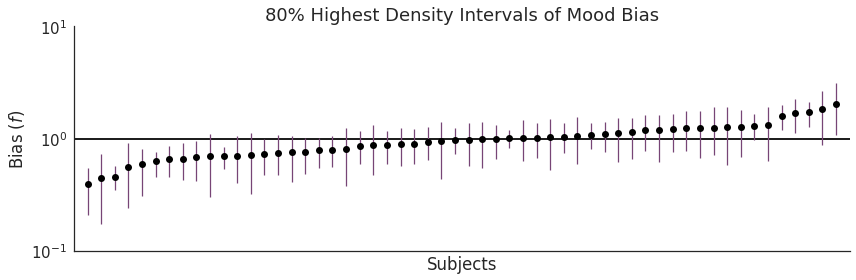

In [18]:
from scripts.utilities import HDIofMCMC

## Load StanFit.
fit = load_fit('moodRL_wald_full_mood_glob')

## Extract f.
f = fit['f']
f = f[:, np.argsort(np.median(f, axis=0))]

## Compute intervals.
mu = np.median(f, axis=0)
lb, ub = np.apply_along_axis(HDIofMCMC, 0, f, 0.80)
yerr = [mu - lb, ub-mu]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.errorbar(np.arange(mu.size), np.median(f, axis=0), yerr=yerr,
            fmt='o', lw=1.25, color='k', ecolor='#774576', capsize=10)
ax.set_yscale('log')
ax.hlines(1,-1,f.shape[-1],zorder=0)
ax.set(xticks=[], xlim=(-1,f.shape[-1]), xlabel='Subjects', yticks=[0.1, 1, 10], ylabel=r'Bias ($f$)',
       title='80% Highest Density Intervals of Mood Bias')

sns.despine()
plt.tight_layout()